In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
df_titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
test_id = df_test['PassengerId']

# Data Understanding

In [3]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


-  We can see that there are many null values in the **Cabin** and **Age** and **Embarked** columns
-  The columns **Name**, **Sex**, **Ticket**, **Cabin**, **Embarked** are categorical

In [5]:
df_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_titanic.duplicated().sum()

0

there are no duplicated values in the dataset

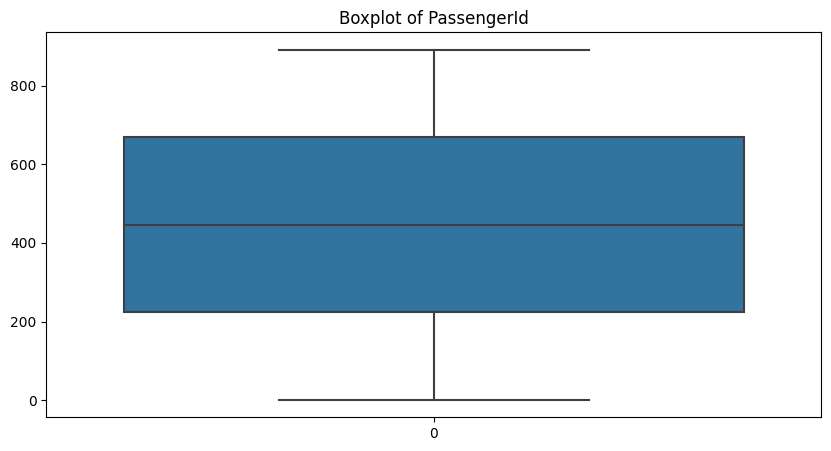

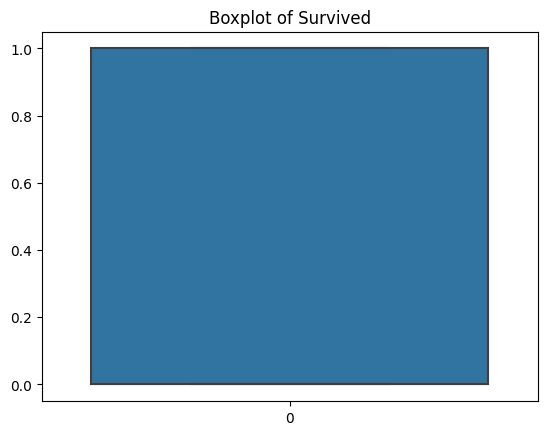

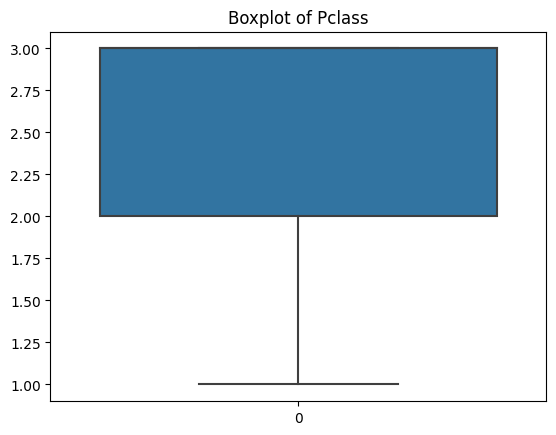

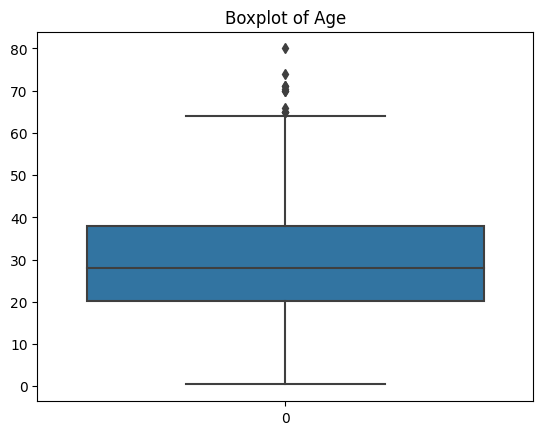

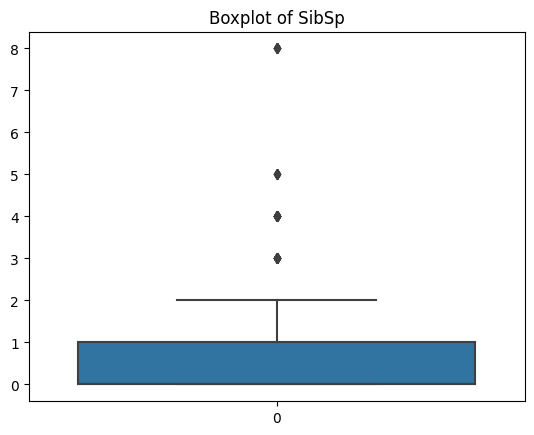

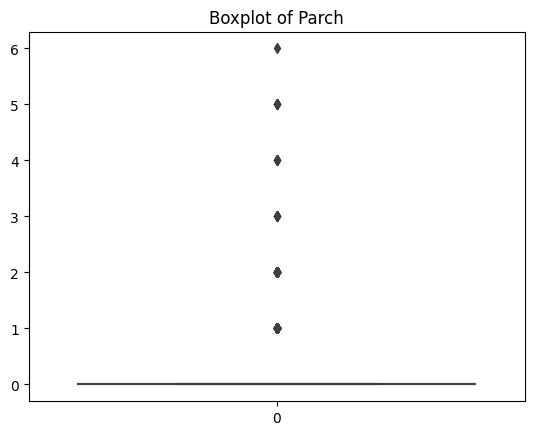

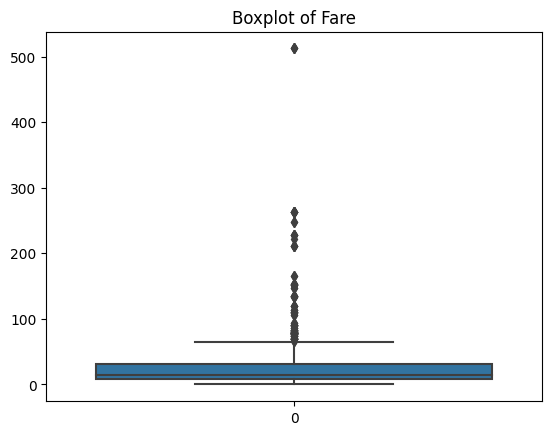

In [7]:
numeric_col = df_titanic.select_dtypes('number').columns

plt.figure(figsize = (10,5))
for i in numeric_col:
    sns.boxplot(df_titanic[i])
    plt.title(f'Boxplot of {i}')
    plt.show()

there are some outliers in **Fare**, **Parch**, **SibSp**, **Age**

# Data preprocessing

In [8]:
# droping unneeded columns
df_titanic.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df_test.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [9]:
df_titanic['Age'].fillna(df_titanic['Age'].median(), inplace = True)
df_titanic['Embarked'].fillna(df_titanic['Embarked'].mode(), inplace = True)

df_test['Age'].fillna(df_test['Age'].median(), inplace = True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace = True)

In [10]:
# converting categorical values to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cols = df_titanic.select_dtypes(include = 'object').columns

for col in cols:
    df_titanic[col] = le.fit_transform(df_titanic[col])
    df_test[col] = le.transform(df_test[col])

In [11]:
from sklearn.model_selection import train_test_split

X = df_titanic.drop(columns = 'Survived')
y = df_titanic['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = .8, random_state = 42)

# Model

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
hyper_param = {
    'max_depth':[3,7,10],
    'min_samples_split':[2,3,4],
    'max_features':[3,4]
}
grid_search = GridSearchCV(estimator= rf, param_grid= hyper_param, cv = 4, n_jobs= -1, verbose = 3)

In [13]:
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 7, 10], 'max_features': [3, 4],
                         'min_samples_split': [2, 3, 4]},
             verbose=3)

In [14]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=7, max_features=3, min_samples_split=4,
                       random_state=42)

In [15]:
y_pred = grid_search.predict(X_val)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [17]:
prediction = grid_search.predict(df_test)

In [18]:
result = pd.DataFrame({'PassengerId':test_id.values, 'Survived':prediction})

In [19]:
result.to_csv('submission.csv', index=False)